# Run The Agent on Mountain Car

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

import pandas as pd

In [2]:
from vae_recurrent import VAE, create_decoder, create_encoder
from transition_gru import TransitionGRU
from recurrent_agent import DAIFAgentRecurrent
from prior_model import PriorModelBellman
from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward
from ddpg import *

In [3]:
from util import random_observation_sequence, transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

In [4]:
# from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [5]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

## Test with no prior model FEEF

In [6]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 2

# make the VAE
enc = create_encoder(2, latent_dim, [20])
dec = create_decoder(latent_dim, 2, [20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=False)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionGRU(latent_dim, 1, 2*pln_hrzn*latent_dim, 2, train_epochs=2, show_training=False)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=False)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())

# # make the HABIT ACTION NET
actor_model = get_actor(2, 1)
critic_model = get_critic(2, 1)
target_actor = get_actor(2, 1)
target_critic = get_critic(2, 1)

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())
critic_optimizer = tf.keras.optimizers.Adam(0.0001)
actor_optimizer = tf.keras.optimizers.Adam(0.00005)
habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)


# make the PRIOR NET
prior_model = PriorModelBellman(latent_dim, output_dim=1, show_training=False, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0.45, 0]
prior_stddev = [1, 1]

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0])  # no noise on prior

In [7]:
daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           # habit_net,
                           None,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=True,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=False,
                           train_prior_model=False,
                           train_tran=True,
                           train_during_episode=True,
                           train_with_replay=True,
                           use_fast_thinking=False,
                           habit_model_type="A2C",
                           uncertainty_tolerance=0.1,
                           min_rewards_needed_to_train_prior=-10,
                           prior_model_scaling_factor=1)


daifa.train_prior = True
daifa.prior_model.show_training = False

In [8]:
daifa = DAIFAgentRecurrent(None,
                           vae,
                           tran,
                           None,
                           given_prior_mean=scaled_prior_mean,
                           given_prior_stddev=prior_stddev,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=True,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=False,
                           train_prior_model=False,
                           train_tran=True,
                           train_during_episode=True,
                           train_with_replay=False,
                           use_fast_thinking=False,
                           habit_model_type=None)

In [12]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_one = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=5, render_env=True)

Episode 1
[-0.5090015  0.       ]
0 91
Success in episode 1 at time step 543 with reward 92.71602234750388
Episode 2
[-0.44213268  0.        ]
0 22
Success in episode 2 at time step 129 with reward 98.13290086834049
Episode 3
[-0.4467717  0.       ]
0 26
Success in episode 3 at time step 153 with reward 97.79505775551824
Episode 4
[-0.59060246  0.        ]
0 18
Success in episode 4 at time step 105 with reward 98.2209879031206
Episode 5
[-0.49985233  0.        ]
0 31
Success in episode 5 at time step 185 with reward 97.1446203892251


In [36]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-5.419011,1002,167
1,-5.615680,1002,167
2,-5.397792,1002,167
3,-5.596435,1002,167
4,-5.340531,1002,167
5,-5.416874,1002,167
6,-5.447138,1002,167
7,-5.803966,1002,167
8,-5.510533,1002,167
9,-5.364049,1002,167


In [37]:
daifa.train_vae = False
daifa.model_vae.show_training = False

In [12]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.52555466  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
11 26
Success in episode 1 at time step 153 with reward 98.87212193391754
Episode 2
[-0.4083196  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
22 43
Success in episode 2 at time step 255 with reward 98.26732539489204
Episode 3
[-0.4488173  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
7 26
Success in episode 3 at time step 153 with reward 98.56496196003238
Episode

In [13]:
# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())
#
# daifa.habit_action_model = habit_net
#
# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [14]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.554270,438,73
1,99.569276,318,53
2,99.649610,234,39
3,99.645730,408,68
4,99.632997,432,72
5,99.740453,324,54
6,99.701746,282,47
7,99.668913,312,52
8,99.674530,312,52
9,99.592478,348,58


In [15]:
daifa.habit_action_model.show_training = False
daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

# daifa.tran.show_training = False
# daifa.prior_model.show_training = False

# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_three = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.5780039  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
15 30
Success in episode 1 at time step 176 with reward 98.75624837284487
Episode 2
[-0.4144444  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
21 36
Success in episode 2 at time step 215 with reward 98.62397342343428
Episode 3
[-0.48184434  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
trai

In [16]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,99.394423,270,45
1,99.336990,306,51
2,99.318876,246,41
3,99.502011,228,38
4,99.671798,246,41
5,99.702185,204,34
6,99.505860,270,45
7,99.441102,234,39
8,99.406625,306,51
9,99.327237,234,39


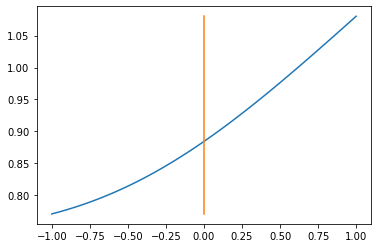

In [17]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

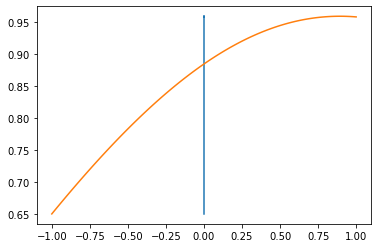

In [18]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

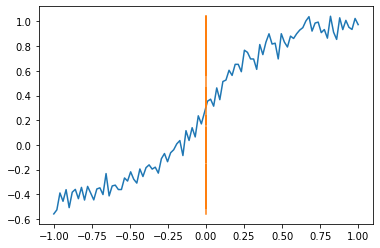

In [19]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

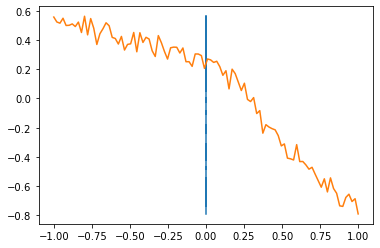

In [20]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [21]:
env = gym.make('MountainCarContinuous-v0')
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res

,reward,timesteps,num_actions
0,99.551576,234,39
1,99.641363,234,39
2,99.654589,210,35
3,99.415635,228,38
4,99.472602,288,48


In [131]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=False)

Episode 1
[-0.5289152  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
58 167
No Success
Episode 2
[-0.4862981  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast think

In [132]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-1.116215,1002,167
1,-1.212457,1002,167
2,-1.124586,1002,167
3,-1.146133,1002,167
4,-1.031558,1002,167
5,-1.005472,1002,167
6,-1.113222,1002,167
7,-1.095383,1002,167
8,-1.133273,1002,167
9,-1.105315,1002,167


In [133]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=True)

Episode 1
[-0.48857218  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
10 23
Success in episode 1 at time step 138 with reward 98.80083488426415
Episode 2
[-0.45492125  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
11 23
Success in episode 2 at time step 135 with reward 99.03274588096102
Episode 3
[-0.592322  0.      ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
16 29
Success in episode 3 at time step 172 with reward 99.05821167172125
Episode 4
[-0.5740812  0.       ]
fast thinking


In [134]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-2.523213,1002,167
1,-2.337758,1002,167
2,-2.547852,1002,167
3,-2.682851,1002,167
4,-2.520970,1002,167
5,-2.681220,1002,167
6,-2.517455,1002,167
7,-2.678760,1002,167
8,-2.782867,1002,167
9,-2.572992,1002,167


In [135]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 4, daifa.agent_time_ratio, show_env=True)
res

,reward,timesteps,num_actions
0,-2.485499,1002,167
1,-2.569951,1002,167
2,-2.548640,1002,167
3,-2.615086,1002,167


In [136]:
full_results = pd.concat([results_one, results_two, results_three, results_four])
full_results.reset_index(drop=True)
full_results

,episode,success,sim_steps,VFE_post_run,noise_stddev,percent_use_fast_thinking,total_reward,agent_time_ratio
0,0,True,182,100.012047,"[0.05, 0.05]",0.000000,97.263471,6
1,1,True,556,61.047001,"[0.05, 0.05]",0.107527,93.310212,6
2,2,True,475,47.924458,"[0.05, 0.05]",0.112500,93.648990,6
3,3,True,648,39.060322,"[0.05, 0.05]",0.092593,91.255415,6
4,4,True,492,35.430954,"[0.05, 0.05]",0.048780,93.227870,6
...,...,...,...,...,...,...,...,...
45,45,True,138,9.007255,"[0.05, 0.05]",0.478261,98.965886,6
46,46,True,180,10.332462,"[0.05, 0.05]",0.566667,98.518889,6
47,47,True,138,9.227115,"[0.05, 0.05]",0.391304,98.726049,6
48,48,True,132,7.785805,"[0.05, 0.05]",0.454545,98.969372,6


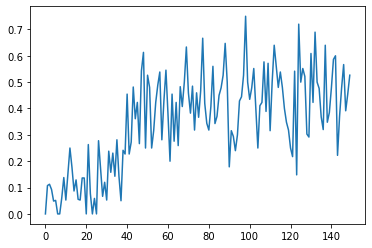

In [137]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

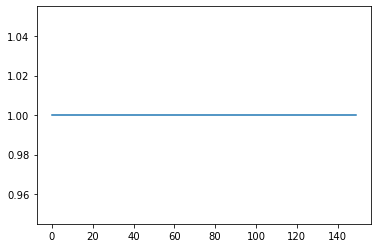

In [138]:
plt.plot(T, full_results.success)

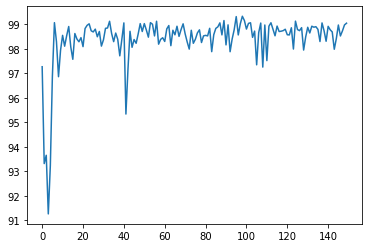

In [139]:
plt.plot(T, full_results.total_reward)

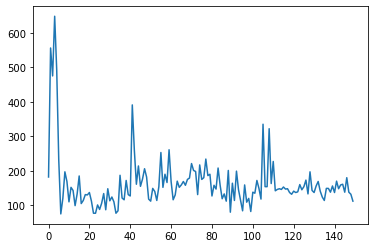

In [140]:
plt.plot(T, full_results.sim_steps)